In [1]:
import sys
import os
import pandas as pd
import numpy as np
import pickle

## replace with root project dir
PROJECT_DIR = "/mnt/workspace/__ing/llming/DTC/course"
sys.path.append(PROJECT_DIR)

from utils.huggingface import (
    setup_hf_cache_dir,
    setup_transformers_cache_dir,
    setup_sentence_transformers_cache_dir,
    vectorize_sentences,
)
from utils.utils import (
    initialize_env_variables,
    load_json_document,
    id_documents,
)

from utils.elasticsearch import (
    elastic_search,
    create_elasticsearch_client,
    search_elasticsearch_indecis,
    load_index_settings,
    create_elasticsearch_index,
    remove_elasticsearch_index,
    index_documents,
    knn_elastic_search,
    get_index_mapping,
    
)

from utils.query import (
    search,
    build_prompt,
    llm,
    rag,
)

from utils.groundtruth import generate_questions_using_openai

from utils.evaluate import (
    calculate_relevance,
    hit_rate,
    mrr,
    llm_as_a_judge,
)

from utils import minsearch

from utils.ollama import (
    embed_documents,
    get_embedding,
)

## HF_HOME
setup_hf_cache_dir(
    os.path.join(PROJECT_DIR, "hf_cache")
)
## TRANSFORMERS_CACHE
setup_transformers_cache_dir(
    os.path.join(PROJECT_DIR, "hf_cache/transformers_cache")
)
## SENTENCE_TRANSFORMERS_HOME
setup_sentence_transformers_cache_dir(
    os.path.join(PROJECT_DIR, "hf_cache/transformers_cache")
)

from transformers import T5Tokenizer, T5ForConditionalGeneration
from sentence_transformers import SentenceTransformer
from openai import OpenAI


from utils.multithread import map_progress


initialize_env_variables(PROJECT_DIR)


client = OpenAI(
    base_url='http://localhost:11434/v1/',
    api_key='ollama',
)
print("Initialized Ollama Client")


host = "localhost"
port = 9200
index_name = "course-questions"

es_client = create_elasticsearch_client(host, port)
print(get_index_mapping(es_client, index_name))

HuggingFace cache directory
($HF_HOME) has been set to: /mnt/workspace/__ing/llming/DTC/course/hf_cache

HuggingFace transformers cache directory 
($TRANSFORMERS_CACHE) has been set to: /mnt/workspace/__ing/llming/DTC/course/hf_cache/transformers_cache

HuggingFace sentenct transformers cache directory
($SENTENCE_TRANSFORMERS_HOME) has been set to: /mnt/workspace/__ing/llming/DTC/course/hf_cache/transformers_cache

Initialized environment variables listed in: /mnt/workspace/__ing/llming/DTC/course/.env
Initialized Ollama Client
Connected to Elasticsearch
{'course': 'keyword', 'id': 'keyword', 'question': 'text', 'question_text_vector': 'dense_vector', 'question_vector': 'dense_vector', 'section': 'text', 'text': 'text', 'text_vector': 'dense_vector'}


# Read data

In [2]:
gpt4o_df_path = os.path.join(PROJECT_DIR, "data/4/results-gpt4o.csv")
gpt4o_df = pd.read_csv(gpt4o_df_path)

gpt35_df_path = os.path.join(PROJECT_DIR, "data/4/results-gpt35.csv")
gpt35_df = pd.read_csv(gpt35_df_path)


model_name='locusai/multi-qa-minilm-l6-cos-v1'

# Cosine Similarity

In [38]:
gpt4o_embeddings = map_progress(
    f=lambda text: np.array(
        get_embedding(client, text, model_name)
    ),
    seq=gpt4o_df['answer_llm'],
    max_workers=4,
)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [39]:
orig_embeddings = map_progress(
    f=lambda text: np.array(
        get_embedding(client, text, model_name)
    ),
    seq=gpt4o_df['answer_orig'],
    max_workers=6,
)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [ ]:
gpt35_embeddings = map_progress(
    f=lambda text: np.array(
        get_embedding(client, text, model_name)
    ),
    seq=gpt35_df['answer_llm'],
    max_workers=4,
)

In [41]:
gpt4o_orig_cosine_similarities = []
gpt35_orig_cosine_similarities = []

for i, orig_embedding in enumerate(tqdm(orig_embeddings)):
    gpt4o_embedding = gpt4o_embeddings[i]
    gpt35_embedding = gpt35_embeddings[i]
    
    gpt4o_orig_cosine_similarities.append(
        orig_embedding.dot(gpt4o_embedding)
    )
    gpt35_orig_cosine_similarities.append(
        orig_embedding.dot(gpt35_embedding)
    )

  0%|          | 0/1830 [00:00<?, ?it/s]

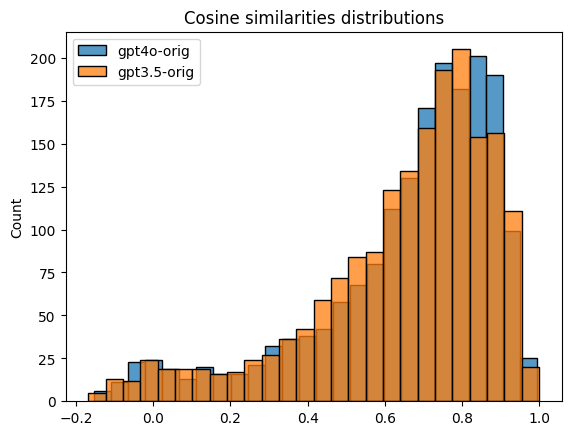

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(gpt4o_orig_cosine_similarities)
sns.histplot(gpt35_orig_cosine_similarities)

plt.legend(['gpt4o-orig','gpt3.5-orig'])
plt.title('Cosine similarities distributions')

plt.show()

In [51]:
print(
    "gpt4o-orig cosine similarities median:",
    np.quantile(gpt4o_orig_cosine_similarities,0.5)
)
print(
    "gpt3.5-orig cosine similarities median:",
    np.quantile(gpt35_orig_cosine_similarities,0.5)
)

gpt4o-orig cosine similarities median: 0.7264333802668093
gpt3.5-orig cosine similarities median: 0.7106725779410131


# LLM as a Judge

In [3]:
client = OpenAI()

llm_as_a_judge_no_ans_path = os.path.join(
    PROJECT_DIR,
    'prompts/llm_as_a_judge_no_answer_provided.txt',
)

sample_df = gpt4o_df.sample(5)

In [4]:
results = llm_as_a_judge(
    client,
    llm_as_a_judge_no_ans_path,
    sample_df,
    model_name="gpt-3.5-turbo",
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
results_df = pd.DataFrame(results)

results_df['Relevance'].value_counts()

Relevance
RELEVANT           3
PARTLY_RELEVANT    2
Name: count, dtype: int64